In [1]:
import numpy as np
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import SGD, Optimizer, Adam
import torch.nn as nn
from pytorch_lightning import Trainer
from scipy.stats import multivariate_normal, sem

from swafa.models import FeedForwardNet 
from swafa.callbacks import FactorAnalysisVariationalInferenceCallback

### Generate some dummy data

In [136]:
def generate_data(
    n_samples: int, 
    feature_covar: np.ndarray, 
    precision: float, 
    random_seed: int,
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    
    n_features = len(feature_covar)

    p_x = MultivariateNormal(loc=torch.zeros(n_features), covariance_matrix=torch.Tensor(feature_covar))
    X = p_x.sample((n_samples,))

    p_theta = MultivariateNormal(loc=torch.zeros(n_features), covariance_matrix=torch.eye(n_features) / precision)
    theta = p_theta.sample().reshape(-1, 1)
    
    logits = X.mm(theta).squeeze()
    probs = torch.sigmoid(logits)
    y = torch.from_numpy(np.random.binomial(1, probs.numpy())).to(torch.float)
    
    return X, y, theta


n_samples = 1000
feature_covar = np.array([
    [1, 0.5], 
    [0.5, 1]
])
precision = 0.01 
random_seed = 4

X, y, theta = generate_data(n_samples, feature_covar, precision, random_seed)

In [137]:
X.shape

torch.Size([1000, 2])

In [138]:
y.shape

torch.Size([1000])

In [139]:
theta

tensor([[10.8973],
        [-9.8238]])

### Compute the true posterior (up to a constant)

In [184]:
def compute_unnormalised_log_prob(
    theta: torch.Tensor, 
    X: torch.Tensor, 
    y: torch.Tensor, 
    precision: float,
) -> float:
    prior_log_prob = compute_prior_log_prob(theta, precision)
    log_likelihood = compute_log_likelihood(theta, X, y)
    
    return prior_log_prob + log_likelihood


def compute_prior_log_prob(theta: torch.Tensor, precision: float) -> float:
    n_features = len(theta)
    
    pdf_theta = MultivariateNormal(loc=torch.zeros(n_features), covariance_matrix=torch.eye(n_features) / precision)
    
    return pdf_theta.log_prob(theta)


def compute_log_likelihood(theta: torch.Tensor, X: torch.Tensor, y: torch.Tensor) -> float:
    logits = X.mm(theta.unsqueeze(1)).squeeze()
    
    return -nn.BCEWithLogitsLoss(reduction='sum')(logits, y)


def compute_posterior(
    theta_range_1: torch.Tensor, 
    theta_range_2: torch.Tensor, 
    X: torch.Tensor, 
    y: torch.Tensor, 
    precision: float,
) -> torch.Tensor:
    
    unnormalised_log_probs = torch.zeros(len(theta_range_1), len(theta_range_2))

    for i, theta_1 in enumerate(theta_range_1):
        for j, theta_2 in enumerate(theta_range_2):
            theta = torch.tensor([theta_1, theta_2])
            unnormalised_log_probs[i, j] = compute_unnormalised_log_prob(theta, X, y, precision)
            
    flattened_probs = nn.functional.softmax(unnormalised_log_probs.flatten(), dim=0)
            
    return flattened_probs.reshape(*unnormalised_log_probs.shape)
            
    
theta_range_1 = torch.arange(7, 12, 0.01)
theta_range_2 = torch.arange(-12, -7, 0.01)
posterior = compute_posterior(theta_range_1, theta_range_2, X, y, precision)

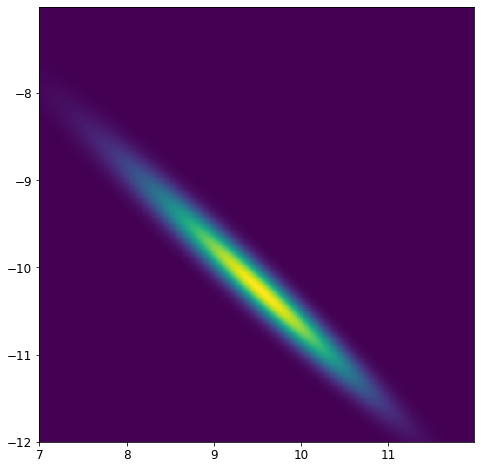

In [187]:
plt.figure(figsize=(8, 8))
c = plt.imshow(
    posterior.flipud().T, interpolation='nearest', 
    extent=(theta_range_1.min(), theta_range_1.max(), theta_range_2.min(), theta_range_2.max())
    #extent=(7, 12, -11, -7)
)

#plt.colorbar(c, ax=c.axes)

plt.show()

### Approximate the posterior using VIFA

In [180]:
latent_dim = 2
n_gradients_per_update = 10
optimiser_class = SGD
bias_optimiser_kwargs = dict(lr=1e-2)
factors_optimiser_kwargs = dict(lr=1e-4)
noise_optimiser_kwargs = dict(lr=1e-2)

batch_size = 100
n_epochs = 5000
max_grad_norm = 10

n_samples, n_features = X.shape

model = FeedForwardNet(
    input_dim=n_features,
    output_activation_fn=torch.sigmoid,
    bias=False,
    optimiser_class=optimiser_class,
    optimiser_kwargs=bias_optimiser_kwargs,
    loss_fn=nn.BCEWithLogitsLoss(reduction='mean'),
    loss_multiplier=n_samples,
    random_seed=random_seed,
)

callback = FactorAnalysisVariationalInferenceCallback(
    latent_dim, 
    precision=precision, 
    n_gradients_per_update=n_gradients_per_update, 
    optimiser_class=optimiser_class, 
    bias_optimiser_kwargs=bias_optimiser_kwargs,
    factors_optimiser_kwargs=factors_optimiser_kwargs,
    noise_optimiser_kwargs=noise_optimiser_kwargs,
    max_grad_norm=max_grad_norm,
    random_seed=random_seed,
)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=False, shuffle=True)

trainer = Trainer(
    max_epochs=n_epochs, callbacks=callback, progress_bar_refresh_rate=0,
)
trainer.fit(model, train_dataloader=dataloader)

variational_mean = callback.get_variational_mean()
variational_covar = callback.get_variational_covariance()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type              | Params
----------------------------------------------------
0 | loss_fn       | BCEWithLogitsLoss | 0     
1 | hidden_layers | ModuleList        | 0     
2 | output_layer  | Linear            | 2     
----------------------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


In [181]:
variational_mean

tensor([ 9.5847, -8.8708])

In [182]:
variational_covar

tensor([[ 0.6003, -0.5340],
        [-0.5340,  0.5078]])

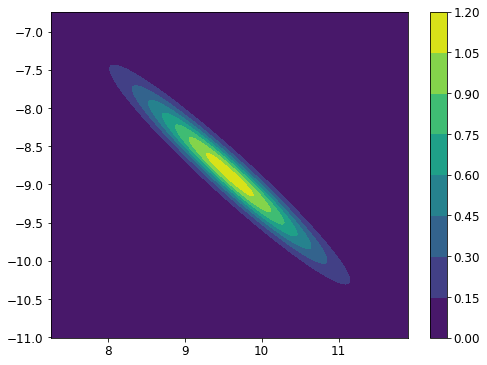

In [183]:
def plot_pdf(mean: np.ndarray, covar: np.ndarray, ax: Axes):
    plt.rcParams.update({'font.size': 12})
    
    x_std3 = np.sqrt(covar[0, 0]) * 3
    x_min = mean[0] - x_std3
    x_max = mean[0] + x_std3

    y_std3 = np.sqrt(covar[1, 1]) * 3
    y_min = mean[1] - y_std3
    y_max = mean[1] + y_std3

    x_grid, y_grid = np.mgrid[x_min:x_max:.01, y_min:y_max:.01]
        
    pos = np.dstack((x_grid, y_grid))
    rv = multivariate_normal(mean, covar)
    c = ax.contourf(x_grid, y_grid, rv.pdf(pos))
    plt.colorbar(c, ax=ax)


fig, axes = plt.subplots(1, 1, figsize=(8, 6))
plot_pdf(variational_mean.numpy(), variational_covar.numpy(), axes)